# Projet Leyenda
## I. Introduction
### 1.1 Introduction au projet

L’entreprise TouNum fait appel à nos services afin d’ajouter à leurs prestations un algorithme de Machine Learning permettant d’améliorer les performances de numérisation de leurs clients. Le premier contrat concerne une solution visant à analyser des photographies afin d’en écrire une légende descriptive automatique, en suivant le concept de captioning.

Cette mission implique plusieurs enjeux : dans un premier temps, les images étant de qualité, définition et résolution pouvant être variables, il faudra nettoyer l’image. De plus, comme ceux-ci comptent travailler sur des types de documents différents, il sera important de savoir trier les documents en question.

![](Images/workflow_projet.png)

Ci-dessus, le Workflow fournit par Tounum. Pour implémenter les algorithmes, nous utiliserons Python (sous forme d’un Notebook Jupyter) ainsi que les librairies SciKit et TensorFlow. D’un point de vue plus mathématique, nous utiliserons également NumPy et MatPlotLib.

Tounum nous fournit également un Dataset dans lequel des images déjà catégorisées permettront d’entraîner nos algorithmes. Dans un premier temps, nous effectuerons une classification binaire via un réseau de neurones afin de classer les fichiers en 2 classes : photos et autres images. Il faudra donc différencier les photos des schémas ainsi que des peintures par exemple.

Pour le captioning, 2 techniques de Machine Learning sont à utiliser. Dans un premier temps, les réseaux de neurones convolutifs, CNN, afin de prétraiter les images. Par la suite, des réseaux de neurones récurrents, RNN, pour générer les étiquettes (descriptions).

Une autre contrainte est à prendre en compte, notamment l’automatisation complète du processus, de l’insertion du jeu de données jusqu’à la création des étiquettes.

3 livrables seront à rendre respectivement fin de semaine 3, fin de semaine 4 et fin de semaine 5 :

- Livrable 1 : Classification Binaire.

- Livrable 2 : Traitement d’images.

- Livrable 3 : Captioning d’images.

Dans ce notebook, vous trouverez le code ainsi que les justifications techniques complètes concernant le livrable 1 sur la classification binaire des images.


### 1.2 Notre équipe de Bordeaux

L'équipe est composé d'étudiants de CESI en option **Data Science** composée de :
- Elise Beaumatin
- Axel Brosset
- Gaylord Giret
- Mathieu Musard
- Xavier Labarbe

### 1.3 Introduction au livrable 1 : Classifieur binaire

Ce notebook nous permettra de présenter le travail effectuer sur le livrable 1. L’objectif de ce livrable est d’identifier les photoraphies parmi un jeu de données de diverses images : schémas, peintures, textes, photos et dessins. Pour se faire, nous utiliserons une modèle de classification binaire. Un modèle de classification binaire est un modèle utilisé pour prédire l'appartenance d'un élément à l'une de deux classes possibles, dans notre cas la classe "Photo" ou "Autre". La sortie du modèle sera un score de probabilité indiquant la probabilité que l'élément appartienne à la classe "Photo".

## II. Importations des modules et des données

### 2.1 Importation des modules

La première chose à faire pour faire fonctionner ce notebook et espèrer modéliser au les données avec les dernières techniques de machine learning tout en exploitant la puissance de certaines librairies Python comme NumPy, TensorFlow et matplotlib, est d'installer et d'importer les librairies Python que nous allons utiliser dans ce notebook. Préalablement, il convient d'installer ces librairies dans notre environnement d'execution avec les commandes **'!pip install'** ou **'!conda install'**, conformément aux instructions indiquées sur les sites de ces librairies. Une fois installées, nous pouvons importer les librairies dans le notebook. Vous pouvez trouvez toutes les librairies que nous avons utilisées dans le bloc de code ci-dessous.




In [4]:
# --- Libraries for preparing and importing data --- # 

import os                          # Import os (Used to create directory and handle images in local machine)
from zipfile import ZipFile        # Import ZipFile class from zipfile (Used to extract archives)
from PIL import Image              # Import Image class from PIL (Used for testing if images are corrupted and for rotating images)i
import shutil                      # Import shutil (Used to move files and remove some directory)
import glob                        # Import global (Used to list all file path in a directory)

# --- Libraries for creating AI model and for handling data --- # 

import tensorflow as tf            # Import TensorFlow (Used for building AI model)
import numpy as np                 # Import Numpy (Used for several useful methods)

# --- Libraries for plotting data --- # 

import plotly.express as px        # Import plotly.express (Used for plotting graph)
import matplotlib.pyplot as plt    # Import pyplot (Used for plotting graph)

# --- Definition of colors code for Jupyter Notebooks (For printing purpose) --- #

yellow = '\033[93m'
green = '\033[92m'
red = '\033[91m'
default = '\033[39m'

### 2.2 Récupération des données

Une fois que nous avons toutes nos librairies, nous allons devoir récupérer les données nécessaires à la réalisation du notebook. En science des données, il existe plusieurs moyens d'obtenir des données. Il est possible de s'appuyer sur des données locales (par exemple des fichiers plat sur notre machine), d'interroger des bases de données, d'interroger des API (Application Programming Interface), ou encore d'extraire des données depuis des sites Web. Dans notre cas le jeu de données est fournis par le CESI à l'URL suivant :   

https://cesifr-my.sharepoint.com/:u:/g/personal/cmeslin_cesi_fr/EZuPZuL19sdLv39Xjvs_S9sBUjUAz2jrRLg37hwctCybFQ?e=UQzPuc

Il s'agit d'une archive au format Zip qui contient elle même plusieurs archives. Ces archives contiennent toutes un dossier qui contient lui-même toutes les images du même classe. Dans le jeu de donnés fournis, les images sontdivisés dans 5 classe : les photographies, les peintures, les schémas, les dessins et les textes. Pour créér un jeu de données tensorflow à partir de ces images il va falloir les extraires les images des archives. Puisque nous sommes dans un problème de classifiation binaire, nous allons extraire les images dans deux dossiers : l'un contenant les photographies et l'autre contenant tous les autres styles d'image.   

Afin de préparer les images à leur utilisation par ce notebook, il faut créer un répertoire à l'emplacement désiré et y déposer les archives contenant les datasets. Voir l'exemple sur l'image suivante. (**Attention ! Une archive doit contenir un ou plusieurs dossier contenant les images, les images ne doivent pas être à la racine de l'archive**)

![](Images/image_datasets_folder.png)

### 2.3 Extraction des données

Maintenant que nous avons créé un répertoire avec toutes les archives, nous pouvons exécuter le code qui permettra d'extraire les images des archives et les organiser dans deux dossiers.

In [5]:
# --- Definition of variables --- #

allow_extraction = False # Boolean : 'True' will extract the data and 'False' will prevent data from being extracted.
datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets" # String : Path to the folder containing the datasets (in ZIP format). 

extracted_datasets_path = os.path.join(datasets_path,'Extracted')  # String : Path to the folder where images will be extracted. 
new_dataset_filename = "Other"  # String : Name of the class for images that aren't photography. 
new_dataset_path = os.path.join(extracted_datasets_path, new_dataset_filename) # String : Path to the folder for images that aren't photography.
datasets_to_regroup = ['Dataset','Painting','Schematics','Sketch','Text'] # List : List of directories to regroup in Other (images that aren't photography.)

# --- Algorithm for extracting images from the achives --- #

if allow_extraction: # If the extraction if images is on True
    if not os.path.exists(extracted_datasets_path): # If the extraction folder isn't created yet
        os.makedirs(extracted_datasets_path) # Creation of the extraction folder
        print(f"{green}Extraction folder successfully created at '{extracted_datasets_path}'")
                
    try: # Try catch used to ignore an error at the end of the execution.
        for dataset_filename in os.listdir(datasets_path): # For all archives in the dataset folder. 
            file_extension = os.path.splitext(dataset_filename)[1] # Retrieve the extension of the current file
            if file_extension == ".zip": # If the file is a zip file
                dataset_path = os.path.join(datasets_path, dataset_filename) # Retrieve the complete path of the archive.
                dataset_zip = ZipFile(dataset_path, 'r') # Create a ZipFile object from the archive. 
                print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
                dataset_zip.extractall(extracted_datasets_path) # Extract the dataset in the extraction path
                print(f"{green}'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")
                dataset_zip.close() # Close the archive
    except:
        pass
    
    # --- Algorithm for adapting the directory to the image_dataset_from_directory method (Tensorflow) --- #
    
    if not os.path.exists(new_dataset_path): # If there is no directory for images that aren't photography
        os.makedirs(new_dataset_path) # Creation of the directory for images that aren't photography
        print(f"{green}New folder successfully created at '{new_dataset_path}'")
    for dataset in os.listdir(extracted_datasets_path): # For all extracted datasets
        if dataset in datasets_to_regroup: # If the dataset contains images that aren't photography
            dataset_directory = os.path.join(extracted_datasets_path, dataset) # Retrieve the full path of the dataset directory
            print(f"Starting the copy of '{dataset_directory}' at '{new_dataset_path}'")
            shutil.copytree(dataset_directory, new_dataset_path, copy_function=shutil.move, dirs_exist_ok=True) # Move images of the current dataset to the directory for images that aren't photography
            print(f"{green}The content of '{dataset_directory}' was successfully extracted at '{new_dataset_path}'")
            shutil.rmtree(dataset_directory) # Remove the old folder
            
    print("All the images has been extracted")

Une fois le code exécuté, nous nous retrouvons avec un dossier nommé "Extracted" qui contient lui même deux dossiers "Photo" et "Other" avec les images à l'intérieur de ces dossiers.

### 2.4 Préparation des données

Il manque maintenant une dernière étape avant d'importer ces données dans un jeu de données TensorFlow. Il s'agit de vérifier que tous les fichiers dans les réportoires contenant les données sont des images et qu'elles peuvent toutes être traitées par dans un code Python. Pour cela nous allons vérifier que toutes les images sont ouvrables avec une librairie conçue pour gérer les images en Python (PIL). Les fichiers qui rencontreront des erreurs d'ouvertures seront supprimés.

Les images du datasets ont des formats très différents, certaines images sont en portrait et d'autres en paysage. Lors de plusieurs essais de modèle, nous avons pu constater à un moment donné, que si les images étaient importés en tant que rectangle au lieu d'un carré, on pouvait avoir de meilleur résultat. A ce moment là nous aions eu comme idée de tourner toutes les images dans un même sens (format paysage) afin de limiter la déformation des images lorsqu'on les redimensionne en rectangle. Nous verrons plutard que cette technique a été abandonnée pour cause de mauvaises performances, cependant le code de rotations des images est toujours disponnible ci-dessous, en parralèle de la vérification des images.


In [6]:
# --- Definition of variables --- #

allow_search_for_corrupted = False # Boolean : 'True' will search for corrupted images and 'False' will prevent it.
allow_rotation = False # Boolean : 'True' will rotate all images that are in portrait mode to switch them to landscape mode.
images_width = [] # List : Empty list that will contain the width of all images
images_height = [] # List : Empty list that will contain the height of all images

# --- Algorithm for searching corrupted images and rotating images --- #

if allow_search_for_corrupted: # If the search of corrupted images is on True
    img_paths = glob.glob(os.path.join(r"C:\Users\axelb\Desktop\Projet DS\Datasets\Extracted",'*/*.*')) # Retrieve the list of path for all images
    for image_path in img_paths: # For all images
        try:
            decoded_img = tf.io.decode_image(tf.io.read_file(image_path)) # Read the image with TensorFlow and transform it in an array
            img_height = decoded_img.shape[0] # Retrieve the height of the image
            img_width = decoded_img.shape[1]  # Retrieve the width of the image
            if img_width < img_height and allow_rotation: # If the image is in portrait mode and we allowed the rotation mode
                print(f"{default}Rotating the image at {image_path}...")
                decoded_img = tf.image.rot90(decoded_img) # Rotate the image in landscape mode
                img_height = decoded_img.shape[0] # Retrieve the new height of the image
                img_width = decoded_img.shape[1] # Retrieve the new width of the image
                
                img = tf.keras.utils.array_to_img(decoded_img) # Go back from the image array into a PIL image
                rgb_img = img.convert('RGB') # Convert the image in RGB (Some error occurs with RGBA images)
                rgb_img.save(image_path) # Replace the image with the new rotated image

            images_width.append(img_width) # Add the width of the image in the array with all widths
            images_height.append(img_height) # Add the height of the image in the array with all heights  
            
        except tf.errors.InvalidArgumentError as e: # If there is an error when opening an image
            print(f"{red}ERROR : Dropping the file at {image_path} because it can't be open...")
            os.remove(image_path) # We remove the image from the dataset
    print(f"{default}All the images has been analysed")
            
print(f"{default}The median of width for all images is {np.median(images_width)}")
print(f"{default}The median of height for all images is {np.median(images_height)}")

The median of width for all images is nan
The median of height for all images is nan


C:\Users\axelb\anaconda3\envs\TensorflowGPU\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\axelb\anaconda3\envs\TensorflowGPU\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### 2.5 Importation des données

Maintenant que toutes les images sont prêtes, nous pouvons les importer dans un jeu de données TensorFlow. Pour cela nous allons utiliser la méthode **"image_dataset_from_directory"**. Cette méthode permet de créer un jeu de données à partir d'un répertoire contenant un ou plusieurs dossiers avec des images. Le nom des dossiers est utilisé commme label pour les images, dans notre cas les labels seront donc "Photo" et "Other".   

Afin de pouvoir entrainer le modèle et le tester sur des données différentes, nous avons répartis ces images en deux jeux de données disctincts. Le jeu de données de test ne sera jamais utilisé pour l'entrainement et vice versa. Pour cela nous utilisant le paramtère **"subset=both"**.    

Lors de l'importation des images, nous devons définir qu'elle sera leur taille dans le jeu de données (elles seront automatiquement redimensionnées par la méthode **"image_dataset_from_directory"**). Pour commencer, nous allons prendre approximativement la taille médianes des images calculés dans le bloc de code supérieur. Cela nous permettra d'éviter de déformer trop les images. Cette taille pourra être modifiée ultérieurement si cela permet d'avoir de meilleurs performances.

In [8]:
# --- Algorithm for creating a tensorflow dataset from images --- #

# Create a training set and a test set of images from a directory
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    extracted_datasets_path,  # Specify the directory where the images are located
    validation_split = 0.2,  # Use 20% of the images for the test set
    seed = 10, # Set a random seed for reproducibility
    image_size = (600, 600), # Resize the images to the median size of images in the dataset
    batch_size=64, # Include 64 images in each batch
    subset = "both" # Include both the training and test sets in the returned dataset
)

print(f"\nThe dataset is composed of these classes : {train_set.class_names}")


for images, labels in train_set: # Iterate over the training set
    print(f"\nThe images of one batch have this shape : {images.shape}")
    print(f"The labels of one batch have this shape : {labels.shape}")
    break # Terminate the loop after the first iteration

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Using 8281 files for validation.

The dataset is composed of these classes : ['Other', 'Photo']

The images of one batch have this shape : (64, 600, 600, 3)
The labels of one batch have this shape : (64,)


Les images sont maintenant toutes réparties dans le jeu de données d'entrainement ou le jeu de données de test. Nous pouvons le vérifier en affichant certaines images de notre jeu d'entrainement. 

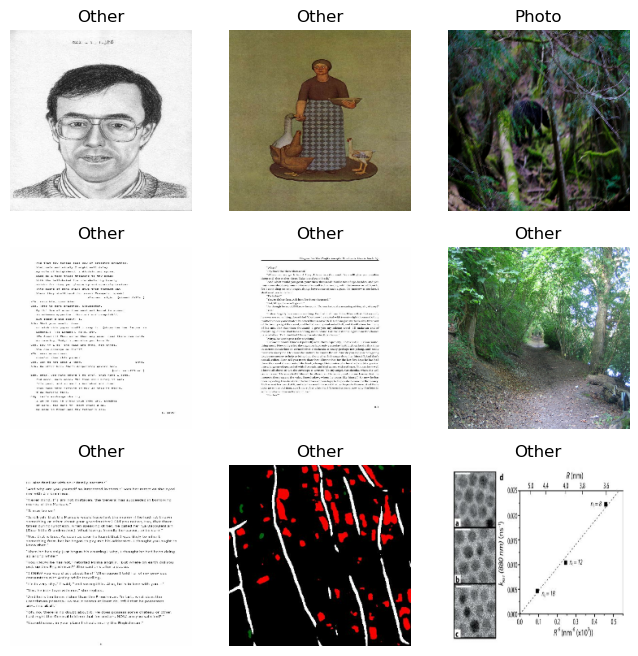

In [9]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[i]])
        plt.axis("off")
plt.show()

## III. Modélisation des données avec un modèle de classification binaire
### 3.1 Modèles basiques
#### 3.1.1 Modélisation avec un simple réseau de neuronnes
##### 3.1.1.1 Définition du modèle

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##### 3.1.1.2 Compilation du modèle

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

##### 3.1.1.3 Entrainement du modèle

In [ ]:
epochs = 10

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

##### 3.1.1.4 Résultat du modèle

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.1.2 Modélisation avec un réseau de neuronnes convolutifs
##### 3.1.2.1 Définition du modèle

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##### 3.1.2.2 Compilation du modèle

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

##### 3.1.2.3 Entrainement du modèle

In [ ]:
epochs = 10

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

##### 3.1.2.4 Résultat du modèle

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.2 Modèles basiques avec régularisation

La régularisation en intelligence artificielle est une technique utilisée pour empêcher ou réduire le surapprentissage d'un modèle de deep learning. La régularisation consiste à ajouter une contrainte au processus d'apprentissage du modèle afin de le forcer à rester simple et généralisable. En utilisant cette technique, on peut améliorer les performances d'un modèle sur de nouvelles données et le rendre plus capable de gérer des situations inattendues.

Il existe plusieurs méthodes de régularisations comme par exemple :

- le **Dropout** : cette méthode consiste à désactiver aléatoirement un pourcentage de neurones d'une couche pendant l'entraînement. Cela permet d'empêcher les neurones de dépendre trop les uns des autres et d'améliorer la généralisation de la modèle à de nouvelles données.


- la **Data Augmentation** : cette méthode consiste à générer de nouvelles données à partir des données d'entraînement existantes en appliquant des transformations aléatoires telles que des rotations, des translations, des miroirs, des changements de luminosité, etc... dans le but d'augmenter la quantité de données disponibles pour l'entraînement d'un modèle.


- la **régularisation L1, L2, Elastic-Net** : ces méthodes consistent à modifier la fonction de coût dans le but de réduire la complexité du modèle en mettant à zéro certains poids (L1), en atténuant les valeurs des poids (L2), ou en combinant ces deux actions (Elastic-Net).


- la **Batch Normalization** : cette méthode consiste à normaliser les activations d'une couche en utilisant les moyennes et les écarts-types des activations de chaque batch d'exemples d'entraînement. Cela a pour effet d'améliorer la convergence et la stabilité des réseaux de neurones.


- l'**Early Stopping** : cette méthode consiste à arrêter l'entraînement d'un modèle avant que la performance ne commence à décliner sur l'ensemble de validation.

#### 3.2.1 Régularisation avec des couches de "Dropout"

Ici, nous allons utiliser un dropout à 20%. Cela signifie que sur toutes les couches suivies d'un dropout, 20% des neurones seront aléatoirement désactivés à chaque itération.

##### 3.2.1.1 Définition du modèle

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255, offset=0.0),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##### 3.2.1.2 Compilation du modèle

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

##### 3.2.1.3 Entrainement du modèle

In [ ]:
epochs = 10

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

##### 3.2.1.4 Résultat du modèle

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.2.2 Autres méthodes de régularisation

En plus du ***"Dropout"**, nous avons également testé les autres méthodes de régularisations citée dans la partie **3.2**. Nous avons également essayé différentes combinaisons avec ces méthodes de régularisation en en ajoutant plusieurs à la fois. L'objectif de cela était d'améliorer un maximum notre modélisation sans changer l'architecture du modèle. Ci-dessous, un tableau regroupe les résultats de toutes les techniques et combinaisons de régularisation utilisées.

| Nom | Précision d'entrainement| Précision de test | Nombre d'époque | Temps moyen par époque|
| :------- |:-----:|:---------:|:---------:|:---------:|
|NN de base (Cf. 3.1.1.1)|0.79|0.76|10|1min20|
|CNN de base (Cf. 3.1.2.1)|0.99|0.91|10|1min50|
|CNN de base (Cf. 3.1.2.1) + data augmentation|0.90|0.86|10|6min40|
|CNN de base (Cf. 3.1.2.1) + rotation des images dans un même sens|0.99|0.91|10|1min40|
|CNN de base (Cf. 3.1.2.1)  + rotation des images dans un même sens + data augmentation|0.90|0.86|10|7-8min|
|CNN avec dropout à 20% (Cf. 3.2.1.1)|0.98|0.90|20|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Data Augmentation|0.89|0.87|10|8-10min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + rotation des images dans un même sens|0.95|0.89|10|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + rotation des images dans un même sens + data augmentation|0.87|0.83|10|8min30|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + DataGenerator|0.87|0.84|10|3min15|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + DataGenerator + DataAugmentation|0.87|0.85|20|5min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same")|0.93|0.93|10|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same") + L1L2 Regularization (Elastic-Net)|0.79|0.70|10|1min45|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same") + Batch Normalization|0.96|0.90|10|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 35% sur toutes les couches|0.93|0.89|15|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 50% sur toutes les couches|0.88|0.90|20|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 50% après la convolution à 32 filtres et après la concolution à 64 filtres |0.91|0.87|10|2min|

### 3.3 Modèles avec des architectures existantes

Enfin, nous avons voulu utiliser des architechtures déjà existants, dans la litterature scientifique. Pour cela, nous avons d'abord choisi de reproduire une architecture existante. Pour cela, nous avons cherché des modèles performants et comprenant relativement peu de couches, afin de pouvoir l'executer sur nos machines. Nous avons alors s'appercevoir sue des forums qu'une personne avait utilisé le modèle VGG-11 sur un problème de classification binaire et qu'il avait obtenue des bons résultats. le modèle étant plutôt simple à mettre en place, nous avons décidé de le tester.

#### 3.3.1 Architecture VGG-11

Le modèle VGG-11 a été développé par l'équipe de recherche Visual Geometry Group (VGG) de l'université de Oxford en 2014. Il a été présenté pour la première fois dans un article de recherche intitulé "Very Deep Convolutional Networks for Large-Scale Image Recognition". Depuis sa publication, le modèle VGG-11 est devenu l'un des modèles de reconnaissance d'images les plus populaires et a été utilisé dans de nombreuses recherches et applications en vision par ordinateur. Il est souvent utilisé comme base pour le développement de nouvelles méthodes en reconnaissance d'images et reste l'un des modèles les plus performants dans de nombreuses tâches de vision par ordinateur.

Ce réseau de neurones a été entraîné sur la base de données ImageNet. Il utilise une architecture de réseau convolutionnel profond avec 11 couches de convolution et 3 couches fully connected. Pour l'exécuter plus rapidement sur nos machines et avoir une architecture moins complexe, nous avons également fait un test sur une architecture simplifié de VGG-11. Poru cela nous avons réduit le nombre de filtre par couche de convolution (division par 8), le nombre de neuronnes sur les couches denses (division par 8) et nous avons retiré une des couches denses, comme en suivant :

```py
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
```

Voici en suivant les résultats obtenus :

| Nom | Précision d'entrainement| Précision de test | Nombre d'époque | Temps moyen par époque|
| :------- |:-----:|:---------:|:---------:|:---------:|
|VGG-11 architecture|0.95|0.91|20|3-4min|
|VGG-11 architecture customisée|0.92|0.91|10|1min30|

L'architecture VGG-11 ne présente pas de meilleurs résultats que le modèle CNN régularisé testée précédement. Le piste de VGG-11 a donc été abadonnée ici, faut de résultat convaincant.

#### 3.3.2 Transfert Learning avec EfficientNetV2B0

EfficientNetV2B0 est un modèle de reconnaissance d'images pré-entraîné développé par Google et publié en 2021, qui utilise une architecture de réseau de neurones convolutionnel (CNN) optimisée pour être efficace en termes de consommation de ressources informatiques tout en conservant une haute performance. Il a été entraîné sur la base de données ImageNet et a été utilisé avec succès dans de nombreuses tâches de vision par ordinateur, telles que la détection d'objets, la classification d'images et la génération de descriptions de contenu d'image. Ce réseau de neurones a été entraîné sur la base de données ImageNet.

Le transfert learning est une technique qui permet de réutiliser les connaissances acquises par un modèle pré-entraîné sur une tâche donnée pour entraîner un nouveau modèle sur une tâche différente. Cela peut être utile lorsqu'il y a peu de données disponibles pour entraîner un modèle sur la tâche spécifique, ou lorsqu'il est difficile de collecter ces données. Le transfert learning peut également aider à améliorer les performances d'un modèle sur une tâche spécifique en utilisant les connaissances acquises par un modèle pré-entraîné sur une tâche similaire.

##### 3.3.2.1 Définition du modèle

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow import keras
from keras import layers

class OwnEfficientNetV2B0:  
    @staticmethod
    def build(input_shape, trainable=False, dropout=0.2):
        inputs = keras.Input(shape=input_shape)

        baseModel = EfficientNetV2B0(weights="imagenet", include_top=False, input_tensor=inputs)
        baseModel.trainable = trainable

        headModel = baseModel.output
        headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = tf.keras.Model(inputs, outputs)

        return model

model = OwnEfficientNetV2B0().build(input_shape=(384, 384, 3))

##### 3.3.2.2 Compilation du modèle

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

##### 3.3.2.3 Entrainement du modèle

In [ ]:
epochs = 10

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

##### 3.3.2.4 Résultats du modèle

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## IV. Résultats et conclusion

| Nom | Précision d'entrainement| Précision de test | Nombre d'époque | Temps moyen par époque|
| :------- |:-----:|:---------:|:---------:|:---------:|
|NN de base (Cf. 3.1.1.1)|0.79|0.76|10|1min20|
|CNN de base (Cf. 3.1.2.1)|0.99|0.91|10|1min50|
|CNN de base (Cf. 3.1.2.1) + data augmentation|0.90|0.86|10|6min40|
|CNN de base (Cf. 3.1.2.1) + rotation des images dans un même sens|0.99|0.91|10|1min40|
|CNN de base (Cf. 3.1.2.1)  + rotation des images dans un même sens + data augmentation|0.90|0.86|10|7-8min|
|CNN avec dropout à 20% (Cf. 3.2.1.1)|0.98|0.90|20|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Data Augmentation|0.89|0.87|10|8-10min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + rotation des images dans un même sens|0.95|0.89|10|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + rotation des images dans un même sens + data augmentation|0.87|0.83|10|8min30|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + DataGenerator|0.87|0.84|10|3min15|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + DataGenerator + DataAugmentation|0.87|0.85|20|5min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same")|0.93|0.93|10|2min|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same") + L1L2 Regularization (Elastic-Net)|0.79|0.70|10|1min45|
|CNN avec dropout à 20% (Cf. 3.2.1.1) + Padding (="same") + Batch Normalization|0.96|0.90|10|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 35% sur toutes les couches|0.93|0.89|15|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 50% sur toutes les couches|0.88|0.90|20|2min|
|CNN de base (Cf. 3.1.2.1) + Dropout 50% après la convolution à 32 filtres et après la concolution à 64 filtres |0.91|0.87|10|2min|
|VGG-11 architecture|0.95|0.91|20|3-4min|
|VGG-11 architecture customisée|0.92|0.91|10|1min30|
|Modèle EfficientNetB0 (gelé) avec modification des deux derniere couches : GlobalAveragePooling2D Dense avec 1 neurone en sigmoid|0.99|0.99|10|3min40|